In [123]:
import pandas as pd

In [128]:
from scipy.cluster.hierarchy import linkage, fcluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, ttest_ind, levene
from itertools import combinations
import matplotlib
import seaborn as sns
from sklearn.cluster import KMeans

# Условие

**В этом домашнем задании вы должны написать свою сплит систему для проведения A/B тестов**

В предоставленных данных есть 50000 юзеров, для каждого есть запись какой-то метрики за 2 года (730 дней).

Данные: https://disk.yandex.ru/d/2mH8fuKCKLeozg


### Ваша задача:

1) Написать алгоритм, которые разбивает данные на 3 группы размера около 5000, которые будут считаться "похожими".

- Для этого вам самостоятельно нужно решить, какие критерии схожести тут применимы и построить необходимые тесты для выбора этих групп.

- Данные 3 группы должны считаться похожими на основе ваших метрик.

- Разбиение затем будет протестировано на следующих 2х годах нами.

2) Визуализировать распределения выбранных вами метрик для найденных групп и сравнить с аналогичными разультатами для случайных групп

### Нужно реализовать следующие функции (вы можете добавлять какие-то побочные, если считаете нужным):

`generate_groups`  - функция, которая по данным и числу групп делает случайное разбиение данных на примерно одинаковые части по количеству групп

`conduct_test_on_pair` - функция проводит статистические тесты между двумя данными группами и возвращает нужные статистики и результаты

`conduct_tests` -- по списку групп и количеству необходимых похожих групп (зафиксировано в условии задачи как 3) перебирает возможные тройки групп пока не найдет похожие, критерий остановки за вами

`find_groups` -- берет данные и число групп, на которое вы их разбиваете и ищет 3 группы удовлетворяющие вашим критериям схожести.

Рекомендуем начинать с того, чтобы искать разбиение на 2 группы, а не 3, чтобы проверить, что сплит система работает адекватно. Задача с двумя группами зачастую сильно проще, чем с тремя.

Группы должны состоять из уникальных клиентов без дубликатов, один клиент может быть только в одной группе. То есть должны выбирать группы из датасета без повторений и у групп не должно быть пересечений.

 Про то, по каким параметрам оценивать группы: в этом задании вам требуется найти группы, в которых распределения **средних значений и дисперсии данной последовательности** по пользователям похожи. То есть вам нужно вычислить среднее значение и дисперсию данной последовательности для каждого пользователя, а затем проверить, что распределения результатов между группами схожи по вашим тестам.


**Замечание**: Для разбиения на группы и сравнения похожести можете брать любую метрику и считать любой критерии, но мы будем сравнивать именно метрику «среднее» и дисперсию на следующих по времени данных

#### Про систему оценивания: При оценивании мы будем проверять полученные вами группы как на этих данных, так и на следующих двух годах. При проверке будем учитывать и качество полученных групп при помощи метрик.

In [129]:
df = pd.read_csv('train_data.csv', delimiter=',')
df.head() # Посомтрим, как выглядят наши данные

,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,...,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30
0,-3.533155,-4.475755,-4.748074,-5.569953,-8.017896,-12.396771,-11.853961,-12.046498,-10.297042,-10.075553,...,-168.163849,-168.728405,-168.971555,-168.824042,-167.700081,-167.634364,-167.856116,-168.743465,-168.231590,-167.913551
1,-3.824475,-1.530769,0.038338,-1.475237,-1.602029,-0.992509,0.302906,1.789140,4.177589,9.273372,...,75.919063,72.909418,75.289867,77.770907,74.099941,72.411474,67.472791,67.084800,66.805609,72.078232
2,-1.616434,-4.658834,-6.746498,-9.979424,-11.683396,-9.507703,-7.614438,-9.735666,-10.754863,-11.058539,...,47.759469,46.596598,50.135737,48.424880,47.740658,46.676116,45.611939,43.331310,45.655325,39.770838
3,-0.157282,1.827617,-2.585284,-4.397189,0.113494,7.614615,5.456654,5.928451,6.953534,4.514409,...,318.364962,319.281629,322.614999,325.200268,324.745069,326.519830,326.467326,321.806523,321.286907,323.570847
4,2.056969,10.187929,8.559520,8.579555,9.464262,9.038088,10.875990,9.883777,8.026472,13.040411,...,-38.079584,-38.515039,-38.031876,-36.610698,-37.753387,-35.470938,-35.454435,-35.026979,-35.633306,-35.460477


## Напишите следующие функции

In [131]:
# Сначала мы сделаем кластеризацию, чтобы выявить похожие группы
# M(x) и D(x) для каждого пользователя
user_means = df.mean(axis=1)
user_variances = df.var(axis=1)
group_num=10

# Массив признаков для каждого пользователя, состоящий из ключевых метрик: матожидания и дисперсии по времени
features = np.column_stack((user_means, user_variances))

# Кластеризация KMeans
kmeans = KMeans(n_clusters=group_num, random_state=42)
kmeans.fit(features)

# Метки кластеров для каждого пользователя
cluster_labels = kmeans.labels_

# Число пользователей в каждой группе
group_size = len(df) // group_num

groups = []

# Делим пользователей на группы
for i in range(group_num):
    cluster_indices = np.where(cluster_labels == i)[0] # Пользователи, принадлежащие кластеру i
    selected_indices = np.random.choice(cluster_indices, group_size, replace=False) # Выборка размера group_size из кластера i
    group_data = df.iloc[selected_indices]
    groups.append(group_data)

# Получим кластеризированные группы, далее увидим, какие кластеры выделились и осознаем, что наибольший кластер - это под индексом 2, остальные кластеры содержат мало наблюдений - значит они сильно отличаются от других кластеров, эти наблюдения стоит убрать из нашей выборки

def conduct_tests_on_pair(df_1, df_2):
    """
    Conducts statistical test or tests on two given groups to decide if they are similar

    df_i : Dataframe of users of a single group

    returns p-value or anything you need further
    """
    means_df_1 = df_1.mean(axis=1)  # Сначала посчитаем среднее значение по времени для каждого пользователя в каждой группе, потом сравним средние значения пользователей двух групп между собой на равенство мат ожидания двух групп
    means_df_2 = df_2.mean(axis=1)

    var_df_1 = df_1.var(axis=1) # То же самое с дисперсиями
    var_df_2 = df_2.var(axis=1)

    stat_tt, p_tt = stats.ttest_ind(means_df_1, means_df_2)
    stat_mw, p_mw = mannwhitneyu(means_df_1, means_df_2)
    stat_lev, p_lev = levene(var_df_1, var_df_2) # На дисперсию

    # print(f'Двусторонний t-тест, тестовая статистика: {stat_tt}, p-value: {p_tt}')
    # print(f'Тест Mann-Witney, тестовая статистика: {stat_mw}, p-value: {p_mw}')
    # print(f'Тест Левене, тестовая статистика: {stat_lev}, p-value: {p_lev}')
    return stat_tt, p_tt, stat_mw, p_mw, stat_lev, p_lev


# print(conduct_tests_on_pair(generated_groups[0], generated_groups[1]))

def conduct_tests(dfs, group_num):
    """
    Goal is to find out if there is group_num groups in the dfs list which are similar enough according to your criterion.
    For every (or maybe not every) selection of group_num groups from the dfs list and conducts pairwise tests on selected subset using conduct_tests_on_pair.

    dfs : list of dataframes of groups

    returns list of selected groups or None if there are no similar groups
    """
    group_combinations = combinations(dfs, group_num) # комбинации групп для проверки
    for combination in group_combinations:
        # Стат тесты для проверки похожести: левене для проверки схожести дисперсий
        p_values_tt = []
        p_values_mw = []
        p_values_lev = []
        for df1, df2 in combinations(combination, 2):
            tt_stat, p_tt, mw_stat, p_mw, lev_stat, p_lev = conduct_tests_on_pair(df1, df2)
            p_values_tt.append(p_tt)
            p_values_mw.append(p_mw)
            p_values_lev.append(p_lev)

        # Будем требовать, чтобы все тесты не отвергались, уровень значимости возьмем побольше, чтобы группы были более похожими
        if all(p > 0.2 for p in p_values_tt) and all(p > 0.2 for p in p_values_mw) and all(p > 0.2 for p in p_values_lev):
            return list(combination)
    return None

def find_groups(df, group_num):
    """
    Splits df into groups and conducts tests on subsets of the groups until necessary groups are found
    """
    for i in range(100000):
        dfs = generate_groups(df, group_num)
        result = conduct_tests(dfs, 3)

        if result is not None:
            return result

ValueError: Cannot take a larger sample than population when 'replace=False'

In [115]:
group1 = generated_groups[:2] + generated_groups[3:]  # Оставили только группы с адекватными значениями средних и дисперсий, которые похожи между собой, согласно кластеризации
all_indices = [index for group in group1 for index in group.index]  # индексы наблюдений, которые надо удалить
df1 = df.copy().drop(all_indices)  # удалим этих юзеров

In [116]:
high_var_indices = df1[df1.var(axis=1) > 9**6].index  # Удалим данные с большой дисперсией, очень шумная дисперсия ломает тесты, поэтому удалим небольшое число шумных наблюдений
high_var_indices.shape
df2 = df1.copy().drop(high_var_indices)

In [99]:
def generate_groups(df, group_num):
    """
    Splits users into group_num groups of similar size

    df : Dataframe with all user data
    group_num : number of groups to split into

    returns a list of dataframes of generated groups
    """
    # permutations обеспечит случайность выбора наших групп, поэтому основные описательные статистики между группами будут равны при большом числе наблюдений, и группы будут похожими
    n_users = len(df)
    indexes_to_choose = np.random.permutation(n_users) # Создадим последовательность перестановок длины n
    group_indexes = np.array_split(indexes_to_choose, group_num) # Поделим данные на равные группы, получим списки индексов для каждой группы (список списков)
    groups = []
    for indexes in group_indexes:
        group = df.iloc[indexes]
        groups.append(group)
    return groups

def conduct_tests_on_pair(df_1, df_2):
    """
    Conducts statistical test or tests on two given groups to decide if they are similar

    df_i : Dataframe of users of a single group

    returns p-value or anything you need further
    """
    means_df_1 = df_1.mean(axis=1)  # Сначала посчитаем среднее значение по времени для каждого пользователя в каждой группе, потом сравним средние значения пользователей двух групп между собой на равенство мат ожидания двух групп
    means_df_2 = df_2.mean(axis=1)

    var_df_1 = df_1.var(axis=1) # То же самое с дисперсиями
    var_df_2 = df_2.var(axis=1)

    stat_tt, p_tt = stats.ttest_ind(means_df_1, means_df_2)
    stat_mw, p_mw = mannwhitneyu(means_df_1, means_df_2)
    stat_lev, p_lev = levene(var_df_1, var_df_2)

    # print(f'Двусторонний t-тест, тестовая статистика: {stat_tt}, p-value: {p_tt}')
    # print(f'Тест Mann-Witney, тестовая статистика: {stat_mw}, p-value: {p_mw}')
    # print(f'Тест Левене, тестовая статистика: {stat_lev}, p-value: {p_lev}')
    return stat_tt, p_tt, stat_mw, p_mw, stat_lev, p_lev


# print(conduct_tests_on_pair(generated_groups[0], generated_groups[1]))

def conduct_tests(dfs, group_num):
    """
    Goal is to find out if there is group_num groups in the dfs list which are similar enough according to your criterion.
    For every (or maybe not every) selection of group_num groups from the dfs list and conducts pairwise tests on selected subset using conduct_tests_on_pair.

    dfs : list of dataframes of groups

    returns list of selected groups or None if there are no similar groups
    """
    group_combinations = combinations(dfs, group_num) # комбинации групп для проверки
    for combination in group_combinations:
        # Стат тесты для проверки похожести: левене для проверки схожести дисперсий
        p_values_tt = []
        p_values_mw = []
        p_values_lev = []
        for df1, df2 in combinations(combination, 2):
            tt_stat, p_tt, mw_stat, p_mw, lev_stat, p_lev = conduct_tests_on_pair(df1, df2)
            p_values_tt.append(p_tt)
            p_values_mw.append(p_mw)
            p_values_lev.append(p_lev)

        # Будем требовать, чтобы все тесты не отвергались, уровень значимости возьмем побольше, чтобы группы были более похожими
        if all(p > 0.2 for p in p_values_tt) and all(p > 0.2 for p in p_values_mw) and all(p > 0.2 for p in p_values_lev):
            return list(combination)
    return None

def find_groups(df, group_num):
    """
    Splits df into groups and conducts tests on subsets of the groups until necessary groups are found
    """
    for i in range(100000):
        dfs = generate_groups(df, group_num)
        result = conduct_tests(dfs, 3)

        if result is not None:
            return result

In [53]:
# groups = generate_groups(df1, 10)

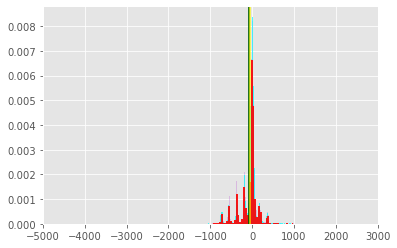

In [117]:
groups = find_groups(df2, 10)
x1 = np.linspace(-1, 1, 100)
y1 = groups[0].mean(axis=1)
y2 = groups[1].mean(axis=1)
y3 = groups[2].mean(axis=1)
fig, ax = plt.subplots(1, 1)
ax.hist(y1, density=True, histtype='bar', bins=300, alpha=0.3, color='mediumorchid')
ax.hist(y2, density=True, histtype='bar', bins=300, alpha=0.7, color='cyan')
ax.hist(y3, density=True, histtype='bar', bins=300, alpha=0.9, color='red')
ax.axvline(np.mean(y1), ymax=1, color='black', alpha=0.8)
ax.axvline(np.mean(y2), ymax=1, color='green', alpha=0.8)
ax.axvline(np.mean(y3), ymax=1, color='yellow', alpha=0.8)
# rect = matplotlib.patches.Rectangle((np.mean(y1)-3*np.std(y1),0), 6*np.std(y1), 0.3, color='black', alpha=0.2)
# ax.add_patch(rect)
plt.xlim(-5000, 3000)
plt.show()

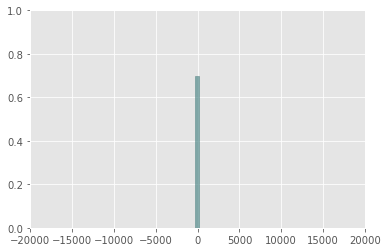

In [118]:
fig, ax = plt.subplots(1, 1)
rect1 = matplotlib.patches.Rectangle((np.mean(y1)-np.std(y1),0), 2*np.std(y1), 0.7, color='black', alpha=0.25)
rect2 = matplotlib.patches.Rectangle((np.mean(y2)-np.std(y2),0), 2*np.std(y2), 0.7, color='red', alpha=0.3)
rect3 = matplotlib.patches.Rectangle((np.mean(y3)-np.std(y3),0), 2*np.std(y3), 0.7, color='cyan', alpha=0.35)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
plt.xlim(-20000, 20000)
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

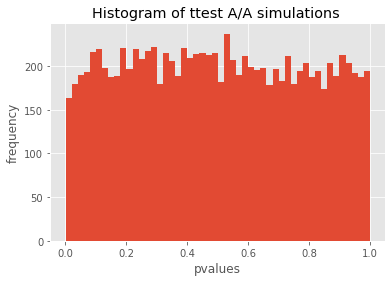

0.045

In [121]:
simulations = 10000
n_s = 100
res = []
from tqdm.auto import tqdm

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
  s1 = y1.sample(n_s, replace = False).values
  s2 = y3.sample(n_s, replace = False).values
  res.append(stats.ttest_ind(s1, s2, equal_var = True)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

In [122]:
from scipy.stats import kstest, uniform

def is_uniform(sample, significance_level):
    # Perform the Kolmogorov-Smirnov test
    _, p_value = kstest(sample, uniform.cdf)

    return p_value

significance_level = 0.05
# Example usage
p_value = is_uniform(res, significance_level)

if p_value > significance_level:
    print("Uniform")  # Sample distribution is likely uniform
else:
    print("Not Uniform")  # Sample distribution is not likely uniform

p_value

Uniform


0.054322475244723556